In [3]:
import importlib
import CTProjector.src.ct_projector.recon.cupy 

# do some work with my_module...

# if you make changes to the code in my_module, you can reload the module like this:
importlib.reload(CTProjector.src.ct_projector.recon.cupy)

<module 'CTProjector.src.ct_projector.recon.cupy' from '/workspace/Documents/CTProjector/src/ct_projector/recon/cupy/__init__.py'>

In [4]:
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt
import nibabel as nb


import HeadCT_motion_correction_PAR.motion_simulator.motion_simulation.ct_basic as basic
import HeadCT_motion_correction_PAR.functions_collection as ff
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform

import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.fan_equiangular as ct_fan
import ct_projector.projector.numpy.fan_equiangluar as numpy_fan

import ct_projector.prior.cupy as ct_prior
import ct_projector.recon.cupy as ct_recon



## Prepare image and sinogram

In [2]:
# load a sample CT image
filename = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/MO101701M000006/MO001A000007/img-nii-2.5/img.nii.gz'
img,spacing,affine = basic.basic_image_processing(filename)
print(img.shape, spacing)

save_folder = '/mnt/mount_zc_NAS/motion_correction/data/test_sinograms/'

# img_ds = ff.crop_or_pad(img,[71,230,230])
img_ds = np.copy(img)
img_ds = img_ds[np.newaxis, ...]
print(img_ds.shape)
truth = img_ds[0,...]/ 0.019 * 1000 - 1024


# plt.figure(figsize = (8,4))
# plt.subplot(121); plt.imshow(ff.set_window(truth[15,...].T,500, 2000), 'gray')
# plt.subplot(122); plt.imshow(ff.set_window(truth[50, :, :].T,50, 100), 'gray')

(71, 234, 234) [2.5266578 1.        1.       ]
(1, 71, 234, 234)


In [6]:
def generate_and_save_sinograms_spline_motion(img, total_angle, amplitude_tx, amplitude_ty, amplitude_tz, amplitude_rx, amplitude_ry, amplitude_rz, file_name , sga = 0, load_file = False, geometry = 'fan', total_view_num = 1000, increment = 100):
    t = np.linspace(0, 500, 5, endpoint=True)
    print(t)
    spline_tx = transform.interp_func(t, np.asarray(amplitude_tx))
    spline_ty = transform.interp_func(t, np.asarray(amplitude_ty))
    spline_tz = transform.interp_func(t, np.asarray(amplitude_tz))
    spline_rx = transform.interp_func(t, np.asarray(amplitude_rx))
    spline_ry = transform.interp_func(t, np.asarray(amplitude_ry))
    spline_rz = transform.interp_func(t, np.asarray(amplitude_rz))

    print(geometry)
    projector = basic.define_forward_projector(img,spacing,total_view_num)
    angles = ff.get_angles_zc(total_view_num, total_angle, sga)

    if load_file == False:
        sinogram = basic.fp_w_spline_motion_model(img, projector, angles,3,  spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, total_view = total_view_num, gantry_rotation_time = 500, slice_num = None, increment = increment, order = 3)

        np.save(file_name, sinogram)
    else:
        sinogram = np.load(file_name, allow_pickle = True)

    return angles, sinogram, total_angle, spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, projector


file_name = os.path.join(save_folder,'spline1.npy')
geometry = 'fan'
sga = 0
angles, sinogram, total_angle, spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, projector = generate_and_save_sinograms_spline_motion(img_ds, 360, np.linspace(0,10,5), np.linspace(0,10,5), np.linspace(0,0,5), np.linspace(0,0/180*np.pi,5), np.linspace(0,0/180*np.pi,5), np.linspace(0,10/180*np.pi,5), file_name , sga = sga, load_file = True, geometry = geometry)

[  0. 125. 250. 375. 500.]
fan


## Make FBP

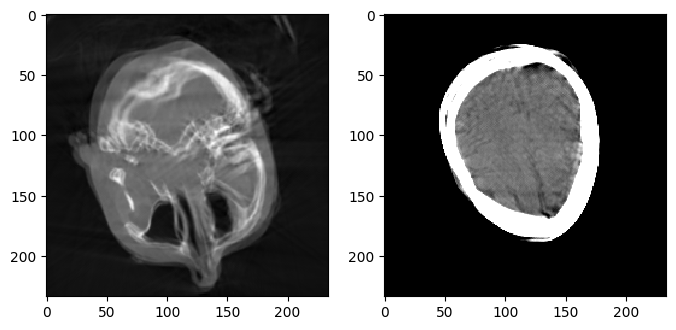

In [7]:
# directly make backprojection
fbp_projector = basic.backprojector(img_ds,spacing)
fbp = basic.filtered_backporjection(sinogram,angles,projector,fbp_projector, geometry, back_to_original_value = True)

truth = img_ds[0,...]/ 0.019 * 1000 - 1024

plt.figure(figsize = (8,4))
plt.subplot(121); plt.imshow(ff.set_window(fbp[15,...].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(fbp[50, :, :].T,50, 100), 'gray')
nb.save(nb.Nifti1Image(np.rollaxis(fbp,0,3),affine), os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','test_sinograms/motion.nii.gz'))

0 [array([-0.]), array([-1.]), array([-1.])] [array([-1.]), array([-0.]), array([-0.])]
1 [array([-0.]), array([-2.]), array([-2.])] [array([-2.]), array([-0.]), array([-0.])]
2 [array([-0.]), array([-3.]), array([-3.])] [array([-3.]), array([-0.]), array([-0.])]
3 [array([-0.]), array([-4.]), array([-4.])] [array([-4.]), array([-0.]), array([-0.])]
4 [array([-0.]), array([-5.]), array([-5.])] [array([-5.]), array([-0.]), array([-0.])]
5 [array([-0.]), array([-6.]), array([-6.])] [array([-6.]), array([-0.]), array([-0.])]
6 [array([-0.]), array([-7.]), array([-7.])] [array([-7.]), array([-0.]), array([-0.])]
7 [array([-0.]), array([-8.]), array([-8.])] [array([-8.]), array([-0.]), array([-0.])]
8 [array([-0.]), array([-9.]), array([-9.])] [array([-9.]), array([-0.]), array([-0.])]
9 [array([-0.]), array([-10.]), array([-10.])] [array([-10.]), array([-0.]), array([-0.])]


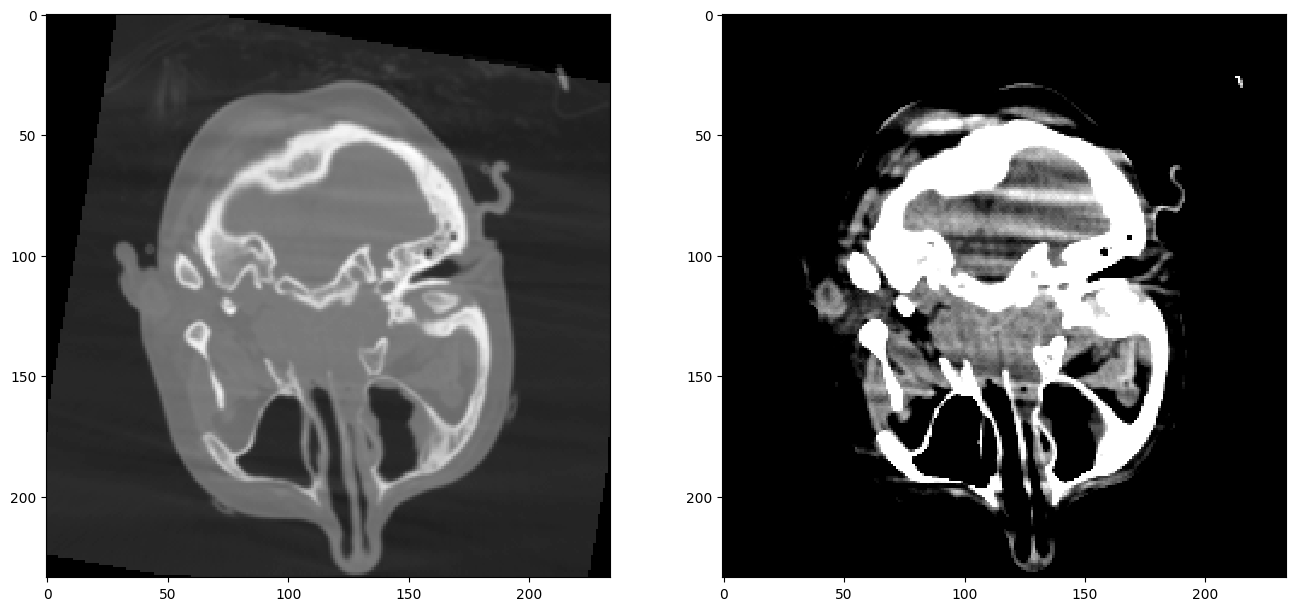

In [8]:
total_views = 1000
gantry_time = 500
# define how many PARs you want to make:
K = 10
# define use whole or half sinogram?
use = 'whole'

if use[0] == 'w':
    sinogram2 = np.copy(sinogram)
    angles2 = np.copy(angles)
    time2 = gantry_time
    
else:
    sinogram2 = sinogram[:, 0: sinogram.shape[1]//2, :, :]
    angles2 = angles[0: sinogram.shape[1]//2]
    time2 = gantry_time/2

# define the time window for each PAR
times = np.linspace(time2/K, time2, K)
    
projector2 = basic.define_forward_projector(img_ds,spacing,sinogram.shape[1])
fbp_projector2 = basic.backprojector(img_ds,spacing)

# divide sinogram:
sinogram_segments,  num_angles_in_one_segment, segment_indexes = basic.divide_sinogram_direct_num(sinogram2, K , sinogram2.shape[1])

##### IMPORTANT  - assign weights to sinogram projection data according to in-plane rotation:
sinogram_weighted, weights = transform.weighted_projection_due_to_rotation(sinogram_segments, segment_indexes, spline_rz, total_views, K,times, angles, sga, use_affine_transform = True)

# make PAR:
final_par = basic.make_PAR_new(sinogram_weighted, segment_indexes,  angles2, img_ds[0,...].shape, projector2, fbp_projector2, geometry = geometry, back_to_original_value=False)

# apply ground truth motion:
PAR_transformed_true_sinogram = np.copy(final_par)
for j in range(0,PAR_transformed_true_sinogram.shape[0]):
    t_end =[times[j]]
    translation_ = [-spline_tz(t_end) , -spline_tx(t_end), -spline_ty(t_end)]
    rotation_ = [-spline_rz(t_end), -spline_rx(t_end), -spline_ry(t_end)] 
    print(j, translation_, [rr/np.pi*180 for rr in rotation_])
    I = final_par[j,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix(translation_,rotation_,[1,1,1],I.shape, which_one_is_first = 'translation') # need to inverse the action
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_new = transform.apply_affine_transform(I, transformation_matrix, order = 3, cval = np.min(I))

    PAR_transformed_true_sinogram[j,...] = img_new

PAR = np.sum(PAR_transformed_true_sinogram,axis=0) / (K) * 2
PAR = PAR / 0.019 * 1000 - 1024
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(ff.set_window(PAR[15,:,:].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(PAR[15,:,:].T,50, 100), 'gray')

In [9]:
nb.save(nb.Nifti1Image(np.rollaxis(PAR,0,3),affine), os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','test_sinograms/PAR_corrected.nii.gz'))

## Directly recon by Iterative method

(1, 5, 234, 234)


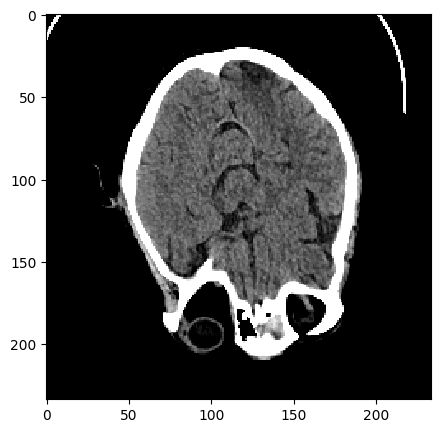

In [5]:
def back_to_HU(recon):
    return recon / 0.019 * 1000 - 1024

filename = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/MO101701M000006/MO001A000007/img-nii-2.5/img.nii.gz'
import SimpleITK as sitk
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
# img = (img.astype(np.float32) + 1024) / 1000
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
# img = img[:, ::-1, ...]
# img = np.copy(img, 'C')
spacing = np.array(spacing[::-1])

img_ds = np.copy(img[:, 30:35,:,:])
print(img_ds.shape)

plt.figure(figsize=[5,5])
plt.imshow(back_to_HU(img_ds[0, 0]), 'gray', vmin=0, vmax=100)

In [6]:
projector_ir = ct_projector.ct_projector()
projector_ir.from_file('projector_fan.cfg')
projector_ir.nv = 1
projector_ir.nz = 1
projector_ir.ny = img_ds.shape[2]
projector_ir.nx = img_ds.shape[3]
projector_ir.du = projector_ir.du * projector_ir.dso / projector_ir.dsd 
# projector_ir.du = projector.dx * projector.dsd / projector.dso / 2

projector_ir.dx = spacing[2]
projector_ir.dy = spacing[1]
projector_ir.dz = spacing[0]

projector_ir.nview = 1000
# for k in vars(projector_ir):
#     print (k, '=', getattr(projector_ir, k))

angles = ff.get_angles_zc(1000, 360,0)

origin_img = img_ds[0,...]
origin_img = origin_img[:,np.newaxis,...]
print(origin_img.shape)

(5, 1, 234, 234)


projection shape:  (5, 1000, 1, 736)
fbp shape:  (5, 1, 234, 234)


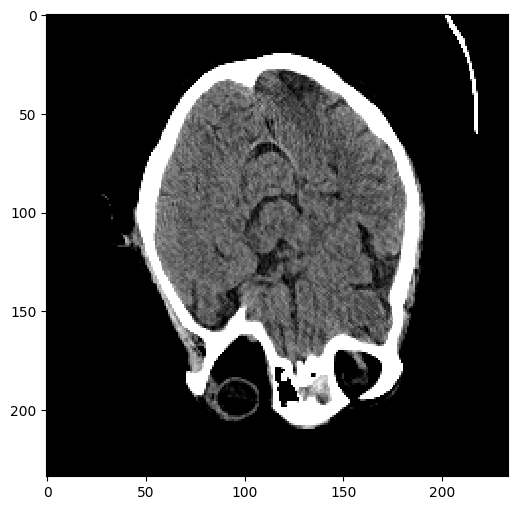

In [7]:
curef = cp.array(origin_img, order='C')
cuangles = cp.array(angles, order='C')

projector_ir.set_projector(ct_fan.distance_driven_fp, angles=cuangles, branchless = False)
projector_ir.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp = True)

cuprj = projector_ir.fp(curef, angles=cuangles)
prj = cuprj.get()
print('projection shape: ',prj.shape)

fprj = numpy_fan.ramp_filter(projector_ir, prj, filter_type = 'rl')
cufprj = cp.array(fprj, cp.float32, order = 'C')
fbp = projector_ir.bp(cufprj)
fbp = fbp.get()

print('fbp shape: ',fbp.shape)
plt.figure(figsize=[6,6])
plt.imshow(back_to_HU(fbp[0, 0]), 'gray',vmin=0, vmax=100)

In [8]:
# PAR_corrected = PAR[30:35,np.newaxis,...]
# sinogram_part = sinogram[30:35,...]


# TV reconstruction
niter = 2
nos = 12  ######## what's os and nos?
nesterov = 0.5
beta = 0.001
zero_init = False

projector_norm = projector_ir.calc_projector_norm()
cunorm_img = projector_ir.calc_norm_img() / projector_norm / projector_norm
print('norm image shape: ',cunorm_img.shape)

cufbp = cp.array(fbp ,order='C')
cuprj2 = cp.array(prj, cp.float32, order = 'C')
cuangles = cp.array(angles, order='C')

# print(cufbp.shape, cuprj.shape, cuangles.shape)

if zero_init:
    curecon = cp.zeros(cufbp.shape, cp.float32)
    cunesterov = cp.zeros(cufbp.shape, cp.float32)
else:    
    curecon = cp.copy(cufbp)
    cunesterov = cp.copy(curecon)

for i in range(niter):
    for os in range(nos):
        inds = np.arange(os, len(cuangles), nos)   ##### pick a projection view every nos view and do this in an incremental way?
        cuangles_current = cp.copy(cuangles[inds], 'C')
        cuprj_current = cp.copy(cuprj2[:, inds, ...], 'C')
        # print('cuprj.shape: ',cuprj_current.shape)

        curecon, cunesterov = ct_recon.nesterov_acceleration(
            ct_recon.sqs_gaussian_one_step,
            img=curecon,
            img_nesterov=cunesterov,
            recon_kwargs={
                'projector': projector_ir,
                'prj': cuprj2,
                'norm_img': cunorm_img,
                'projector_norm': projector_norm,
                'beta': beta
            }
        )

    if (i + 1) % 10 == 0:
        _, data_loss, prior_loss = ct_recon.sqs_gaussian_one_step(
            projector_ir,
            curecon,
            cuprj2,
            cunorm_img,
            projector_norm,
            beta,
            return_loss=True
        )

        print(i + 1, data_loss, prior_loss)

0,1,2,3,4,5,6,7,8,9,
norm image shape:  (1, 1, 234, 234)


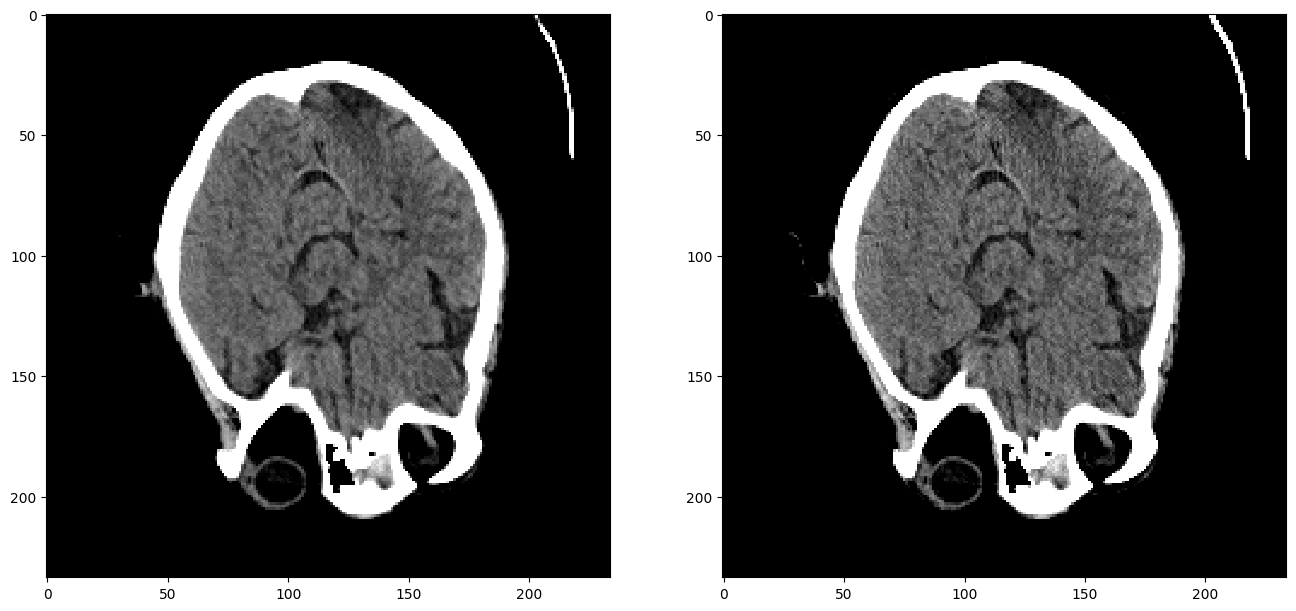

In [7]:
recon_ir = curecon.get()[:,0,:,:]
recon_ir = recon_ir / 0.019 * 1000 - 1024
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(recon_ir[0,...], 'gray', vmin=0, vmax=100)   
plt.subplot(122); plt.imshow(back_to_HU(fbp[0, 0]), 'gray', vmin=0, vmax=100)                  

In [10]:
nb.save(nb.Nifti1Image(np.rollaxis(recon_ir,0,3),affine), '/mnt/mount_zc_NAS/motion_correction/data/test_sinograms/IR_corrected.nii.gz')

NameError: name 'affine' is not defined